## **Getting started**

**Business Objective:**

“Will a customer accept the coupon?” The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those who did not.

**Problem Statement:** Determine which features are most strongly associated with coupon acceptance and provide actionable insights.


**Proposed Process Resolution:**
This notebook analyzes the factors influencing coupon acceptance (Y=1) versus non-acceptance (Y=0):
Coupon Acceptance/Rejection Fetures Discovery/Analysis/Correlation. Including data clensing, correlation analysis, and visualizations that compares key features.


**Findings:**
  **Age** and certain time thresholds (e.g., **toCoupon_GEQ15min** and **toCoupon_GEQ25min**) are strong predictors of coupon acceptance.
  **Some features, like **temperature**, are more related to coupon rejection.



In [41]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

import os
from google.colab import files

In [42]:
#  see collab files

files = os.listdir('/content/')
print(files)


['.config', 'coupons.csv', '.ipynb_checkpoints', '3_coupon_csv-clean-accept-no.csv', '4_top3_features_accepting_coupon.png', '5_top3_features_not_accepting_coupon.png', '2_coupon_csv-clean-accept-yes.csv', 'sample_data']


In [44]:
# upload data csv files

# uploaded = files.upload()


In [45]:
# Read in the dataset to pd df
cpn = pd.read_csv('/content/coupons.csv')

Overall Correlation with Y=1 Acceptanc
Y                    1.000000
toCoupon_GEQ25min    0.053682
direction_same      -0.002065
toCoupon_GEQ15min   -0.034143
temperature         -0.039738
age                 -0.239270
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64

Features sorted by absolute correlation with Y:
age                  0.239270
toCoupon_GEQ25min    0.053682
temperature          0.039738
toCoupon_GEQ15min    0.034143
direction_same       0.002065
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64


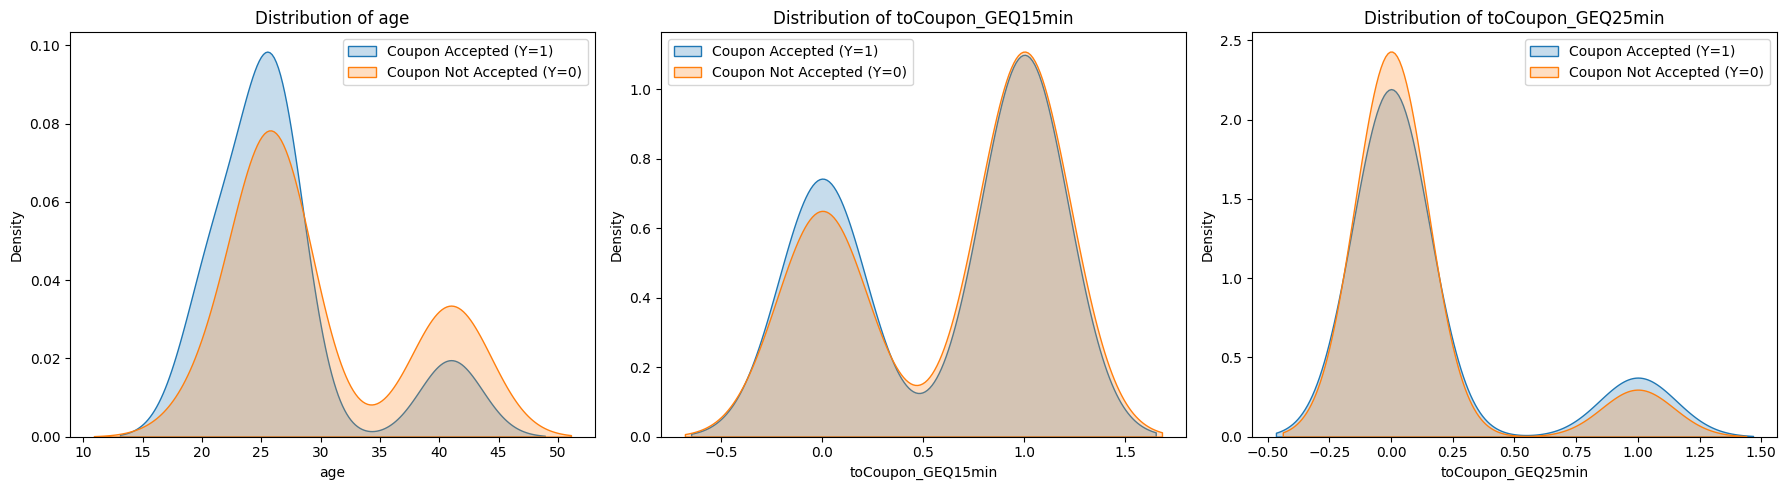


Features sorted by correlation with Y=1 Coupon Acceptance (ascending):
age                 -0.239270
temperature         -0.039738
toCoupon_GEQ15min   -0.034143
direction_same      -0.002065
toCoupon_GEQ25min    0.053682
toCoupon_GEQ5min          NaN
Name: Y, dtype: float64

Top 3 features most correlated with coupon not accepted (Y=0):
age                 -0.239270
temperature         -0.039738
toCoupon_GEQ15min   -0.034143
Name: Y, dtype: float64


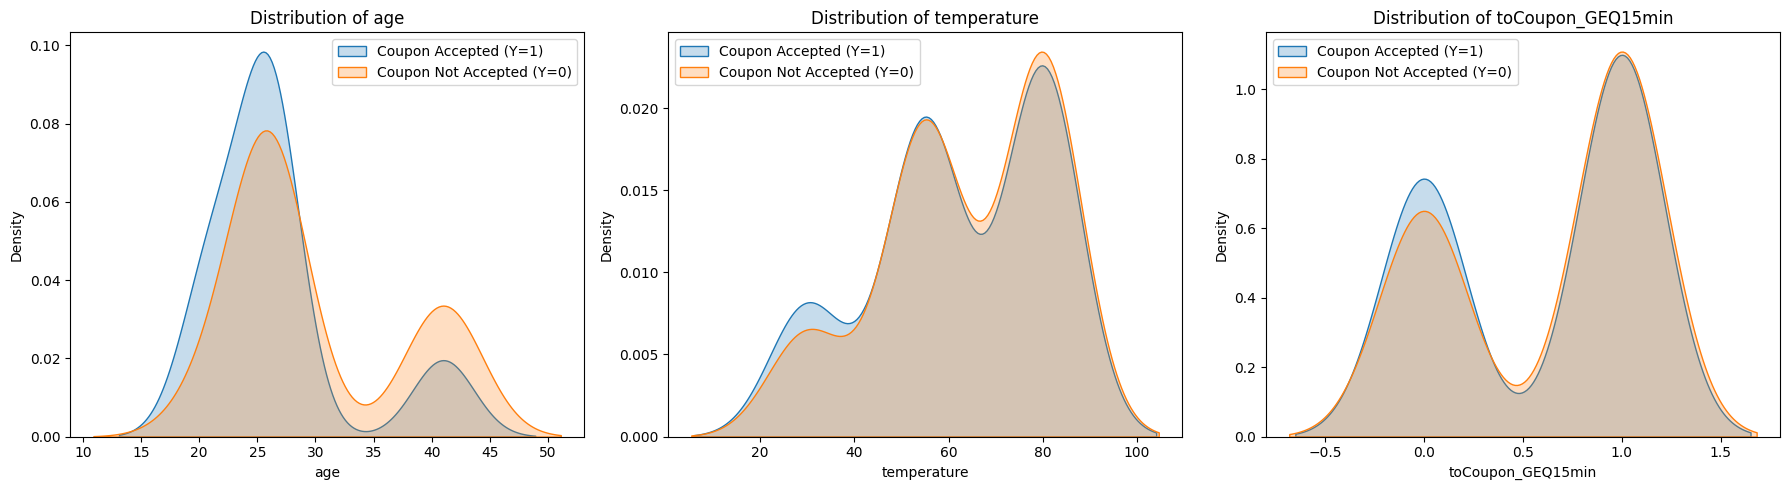

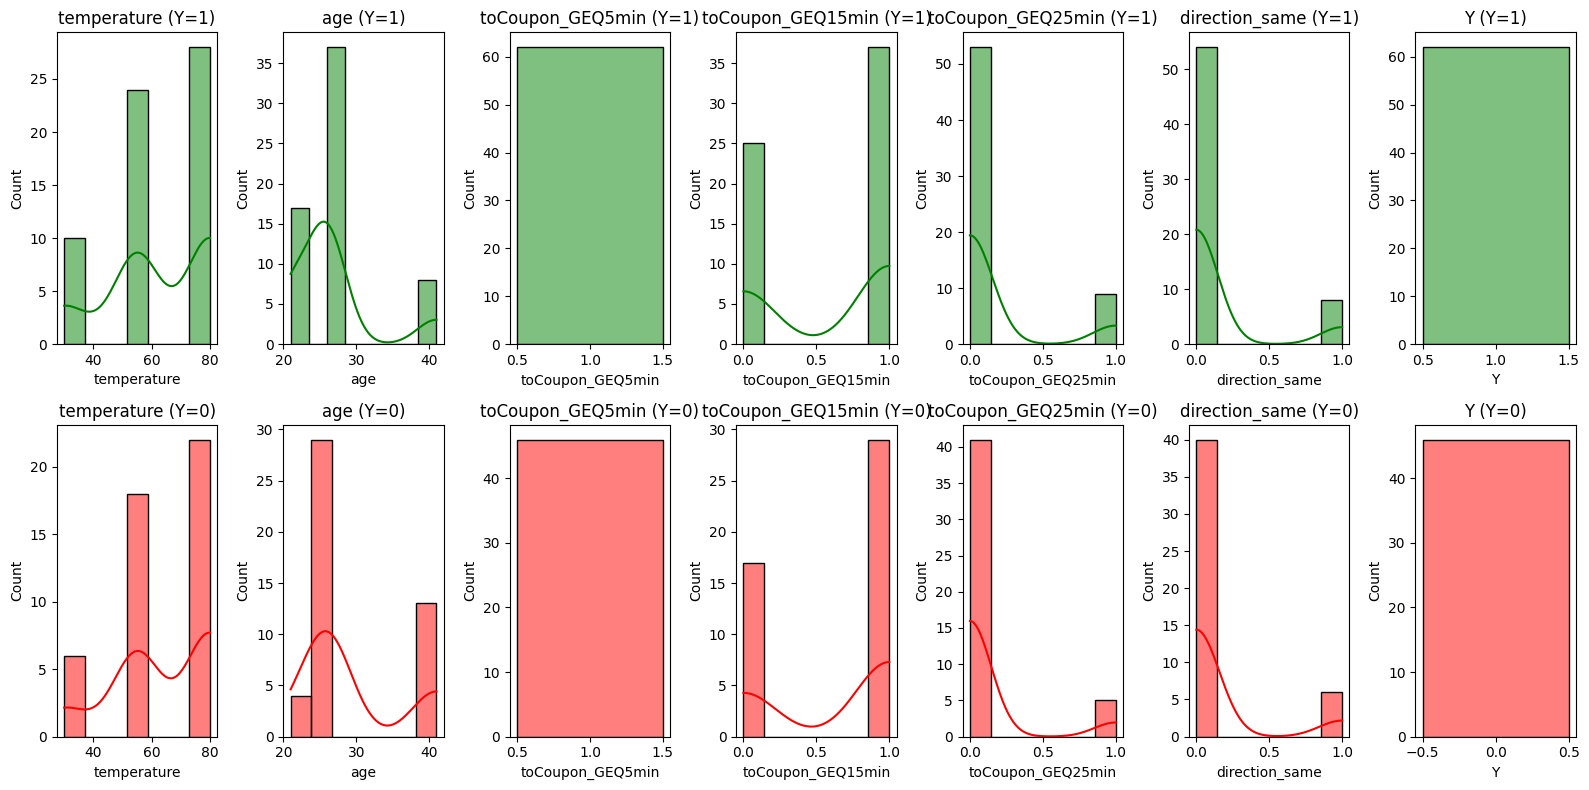

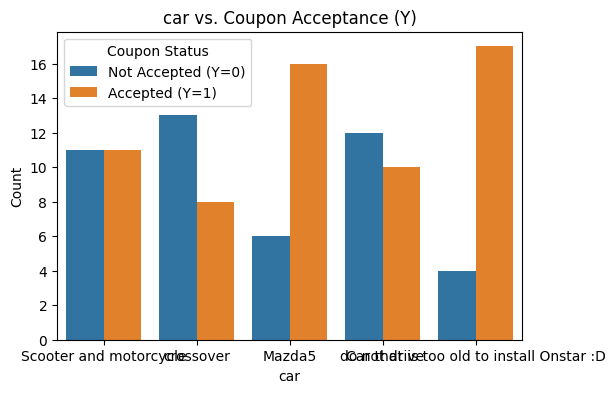

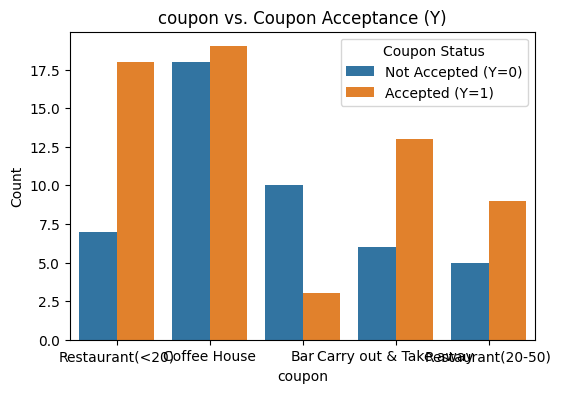

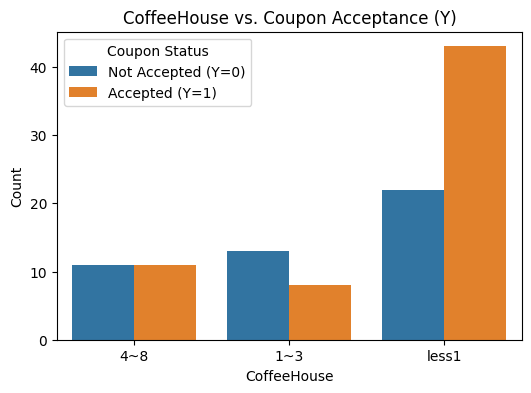

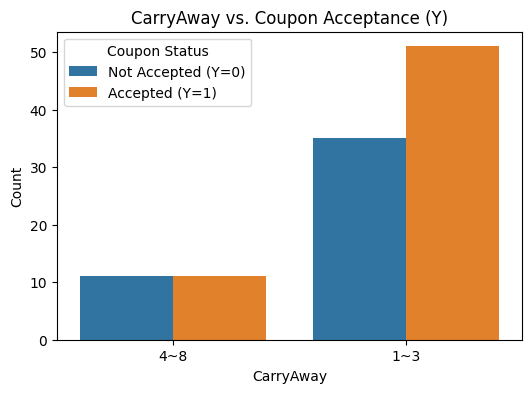

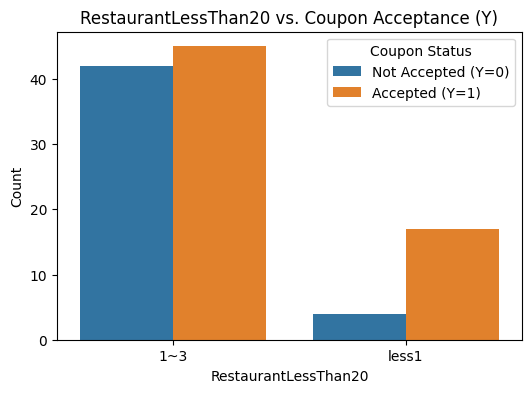

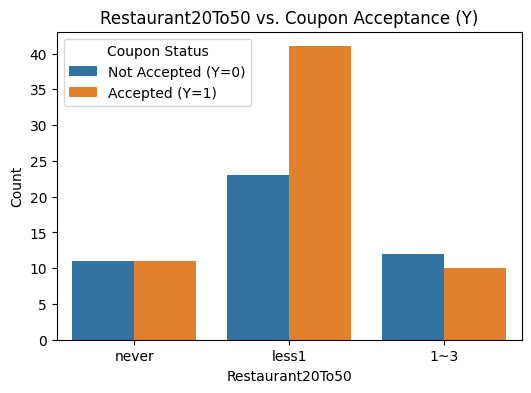

In [48]:
# for UCB 5.1 Coupan db cleanup, exploration, analysis, feature engineering

# %% [markdown]
# ## Data Cleaning & Preparation

# Steps:
# 1. Remove rows with missing values in key columns.
# 2. Drop duplicate rows.
# 3. Convert specific columns to numeric.
# 4. Split the dataset into coupon accepted (Y=1) and not accepted (Y=0).
# 5. Cap outliers at the 1st and 99th percentiles.

# %% [code]
# Define key columns for cleaning
key_columns = [
    'car', 'Bar', 'coupon', 'CoffeeHouse', 'CarryAway',
    'RestaurantLessThan20', 'Restaurant20To50', 'temperature',
    'age', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
    'direction_same', 'Y'
]

# Remove missing and duplicates
cpn = cpn.dropna(subset=key_columns).drop_duplicates().copy()

# Define numeric colmns  & coerce type
numeric_cols = [
    'temperature', 'age', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
    'toCoupon_GEQ25min', 'direction_same', 'Y'
]
for col in numeric_cols:
    cpn[col] = pd.to_numeric(cpn[col], errors='coerce')

# Split data based on coupon acceptance or not
cpnYes = cpn[cpn['Y'] == 1].copy()
cpnNo  = cpn[cpn['Y'] == 0].copy()

# Cap outliers for each numeric column in both groups (1st to 99th percentiles)
for col in numeric_cols:
    lower_cap_yes = cpnYes[col].quantile(0.01)
    upper_cap_yes = cpnYes[col].quantile(0.99)
    cpnYes[col] = cpnYes[col].clip(lower_cap_yes, upper_cap_yes)

    lower_cap_no = cpnNo[col].quantile(0.01)
    upper_cap_no = cpnNo[col].quantile(0.99)
    cpnNo[col] = cpnNo[col].clip(lower_cap_no, upper_cap_no)

# ## save clean data file
cpnYes.to_csv('2_coupon_csv-clean-accept-yes.csv', index=False)
cpnNo.to_csv('3_coupon_csv-clean-accept-no.csv', index=False)

# %% [markdown]
# ## Correlation Analysis

# Corr matrix numeric: ID features strongly associated with coupon acceptance.
# Features with high positive correlation are more prevalent in the coupon accepted group.

# %% [code]
# Compute overall correlation matrix
corr_matrix = cpn[numeric_cols].corr()
print("Overall Correlation with Y=1 Acceptanc")
print(corr_matrix['Y'].sort_values(ascending=False))

# Identify top features by absolute correlation with Y (excluding Y itself)
corr_features = corr_matrix['Y'].drop('Y').abs().sort_values(ascending=False)
print("\nFeatures sorted by absolute correlation with Y:")
print(corr_features)

# %% [markdown]
# ## Coupon Acceptance Analysis
#
# The top three features correlated with coupon acceptance are:
# - **age**
# - **toCoupon_GEQ15min**
# - **toCoupon_GEQ25min**
#
#  see: Plots of distribution for these features ( both coupon acceptance/rejection ).

# %% [PLOTS Seaborn  kdeplot]
features_to_plot = ['age', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']

plt.figure(figsize=(18, 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.savefig("./4_top3_features_accepting_coupon.png")  # Save plot
plt.show()

# %% [markdown]
# ## Coupon Non-Acceptance Analysis
#
# Features with negative correlations (i.e., more associated with coupon non-acceptance).
#  visualize top three features associated with coupon rejection.

# %% [code]
negative_corr_features = corr_matrix['Y'].drop('Y').sort_values()
print("\nFeatures sorted by correlation with Y=1 Coupon Acceptance (ascending):")
print(negative_corr_features)

top3_not_accept = negative_corr_features.head(3)
print("\nTop 3 features most correlated with coupon not accepted (Y=0):")
print(top3_not_accept)

features_to_plot_not_accept = top3_not_accept.index.tolist()

plt.figure(figsize=(18, 5))
for i, feature in enumerate(features_to_plot_not_accept):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.savefig("./5_top3_features_not_accepting_coupon.png")  # Save plot
plt.show()

# %% [markdown]
# ## Additional Feature Exploration
#
# Histograms are plotted for each numeric feature for both coupon accepted and non-accepted groups.
# This helps to further understand the distribution differences.

# %% [code]
fig, axes = plt.subplots(nrows=2, ncols=len(numeric_cols), figsize=(16, 8))
for i, col in enumerate(numeric_cols):
    sns.histplot(cpnYes[col], ax=axes[0, i], kde=True, color='green')
    axes[0, i].set_title(f"{col} (Y=1)")
    sns.histplot(cpnNo[col], ax=axes[1, i], kde=True, color='red')
    axes[1, i].set_title(f"{col} (Y=0)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Categorical Variable Analysis
#
# explore categorical variables and their relation to coupon acceptance using count plots.

# %% [code]
cat_cols = ['car', 'coupon', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Y', data=cpn)
    plt.title(f"{col} vs. Coupon Acceptance (Y)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='Coupon Status', labels=['Not Accepted (Y=0)', 'Accepted (Y=1)'])
    plt.show()




In [ ]:


# Other details

# Visualize distribution of Age
# cpn['age'] = cpn['age'].str.strip("plus")
# cpn['age'] = cpn['age'].str.strip("below")
# cpn['age'].unique()  #['21', '46', '26', '31', '41', '50plus', '36', 'below21']
# cpn['age'] = cpn['age'].astype('float')
# sns.distplot(cpn['age'], bins = 20)
# plt.show()


# cpn.head()

# cpnage = cpn[['car', 'coupon']].dropna().copy()

# sns.cov(cpnage)
# sns.heapmap(cpnage)
# sns.heatmap(cpnage.cov(), annot=True, cmap='coolwarm')
# plt.show()

# car
# Bar
# CoffeeHouse
# CarryAway
# RestaurantLessThan20
# Restaurant20To50

# cpn.dtype

# cpn_clean = cpn.dropna(subset=['car','Bar', 'coupon','CoffeeHouse','CarryAway','RestaurantLessThan20', 'Restaurant20To50'  ])

# sns.boxplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.boxplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.boxplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()


# sns.scatterplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.scatterplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.scatterplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()

# sns.lineplot(x='car', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Car Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['Bar', 'coupon'])
# sns.lineplot(x='Bar', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by Bar Category")
# plt.show()

# cpn_clean = cpn.dropna(subset=['CoffeeHouse', 'coupon'])
# sns.lineplot(x='CoffeeHouse', y='coupon', data=cpn_clean)
# plt.title("Coupon Distribution by CoffeeHouse Category")
# plt.show()


